# Compare the waveforms and spectra (computed with the multitaper method) of the long-period events and hammer shots

In [73]:
# Import modules
from os import makedirs
from os.path import join, exists
from obspy import read, UTCDateTime
from numpy import amax, abs, sqrt
from pandas import DataFrame, Timedelta, Timestamp
from matplotlib.pyplot import subplots

from utils_basic import ROOTDIR
from utils_cc import get_timewin_from_template_name
from utils_hammer import get_timewin_from_hammer_name
from utils_preproc import read_and_process_windowed_waveforms
from utils_snuffler import read_normal_markers, read_phase_markers
from utils_spec import get_disp_psd_mt


In [74]:
# Inputs
## stations and event names
station = "A04"
name_harmo = "BeatA12-17-23-38"
name_hammer = "Hammer10-00-15"

begin_read = -0.15
end_read = 0.25

## Parameters for the multitaper analysis
nw = 2

## Filtering paramgters
freqmin_filt = 10.0
freqmax_filt = 450.0

## Plotting parameters
linewidth_wf = 1.5
linewidth_psd = 1.5

freqmin_plot = 10.0
freqmax_plot = 450.0

## Scale factors for plotting the waveforms and PSDs
scale_wf = 1.05
scale_psd = 3.0

range_psd = 1e5

freq1 = 70.0
freq2 = 85.0
freq3 = 110.0

In [75]:
# Read the snuffler pick files
timewin_harmo = get_timewin_from_template_name(name_harmo)
pickdf_harmo = read_normal_markers(join(ROOTDIR, timewin_harmo, f"xpicks_{name_harmo}.dat"))

timewin_hammer = get_timewin_from_hammer_name(name_hammer)
pickdf_hammer = read_phase_markers(join(ROOTDIR, timewin_hammer, f"ppicks_{name_hammer}.dat"))

In [76]:
# Read and process the data
stream_harmo = read_and_process_windowed_waveforms(pickdf_harmo, freqmin_filt, freqmax_filt, begin=begin_read, end=end_read, stations=[station])
stream_hammer = read_and_process_windowed_waveforms(pickdf_hammer, freqmin_filt, freqmax_filt, begin=begin_read, end=end_read, stations=[station])

A01
A01


In [77]:
# Compute the spectra

## Long-period event

### Get the traces
trace_z = stream_harmo.select(station=station, component="Z")[0]
trace_1 = stream_harmo.select(station=station, component="1")[0]
trace_2 = stream_harmo.select(station=station, component="2")[0]

data_harmo_z = trace_z.data
data_harmo_1 = trace_1.data
data_harmo_2 = trace_2.data

samprat = trace_z.stats.sampling_rate
sampint = trace_z.stats.delta
timeax_harmo = trace_z.times()+begin_read

### Compute the spectra using the multitaper method
freqax, psd_harmo_z = get_disp_psd_mt(data_harmo_z, nw=nw)
_, psd_harmo_1 = get_disp_psd_mt(data_harmo_1, nw=nw)
_, psd_harmo_2 = get_disp_psd_mt(data_harmo_2, nw=nw)

## Hammer shot

### Get the traces
trace_z = stream_hammer.select(station=station, component="Z")[0]
trace_1 = stream_hammer.select(station=station, component="1")[0]
trace_2 = stream_hammer.select(station=station, component="2")[0]

data_hammer_z = trace_z.data
data_hammer_1 = trace_1.data
data_hammer_2 = trace_2.data

samprat = trace_z.stats.sampling_rate
sampint = trace_z.stats.delta
timeax_hammer = trace_z.times()+begin_read

### Compute the spectra using the multitaper method
_, psd_hammer_z = get_disp_psd_mt(data_hammer_z, nw=nw)
_, psd_hammer_1 = get_disp_psd_mt(data_hammer_1, nw=nw)
_, psd_hammer_2 = get_disp_psd_mt(data_hammer_2, nw=nw)

Saved the figure: /Volumes/OmanData/geophones_no_prefilt/data/spetrum_comparison/BeatA12-17-23-38_vs_Hammer10-00-15_A01.png


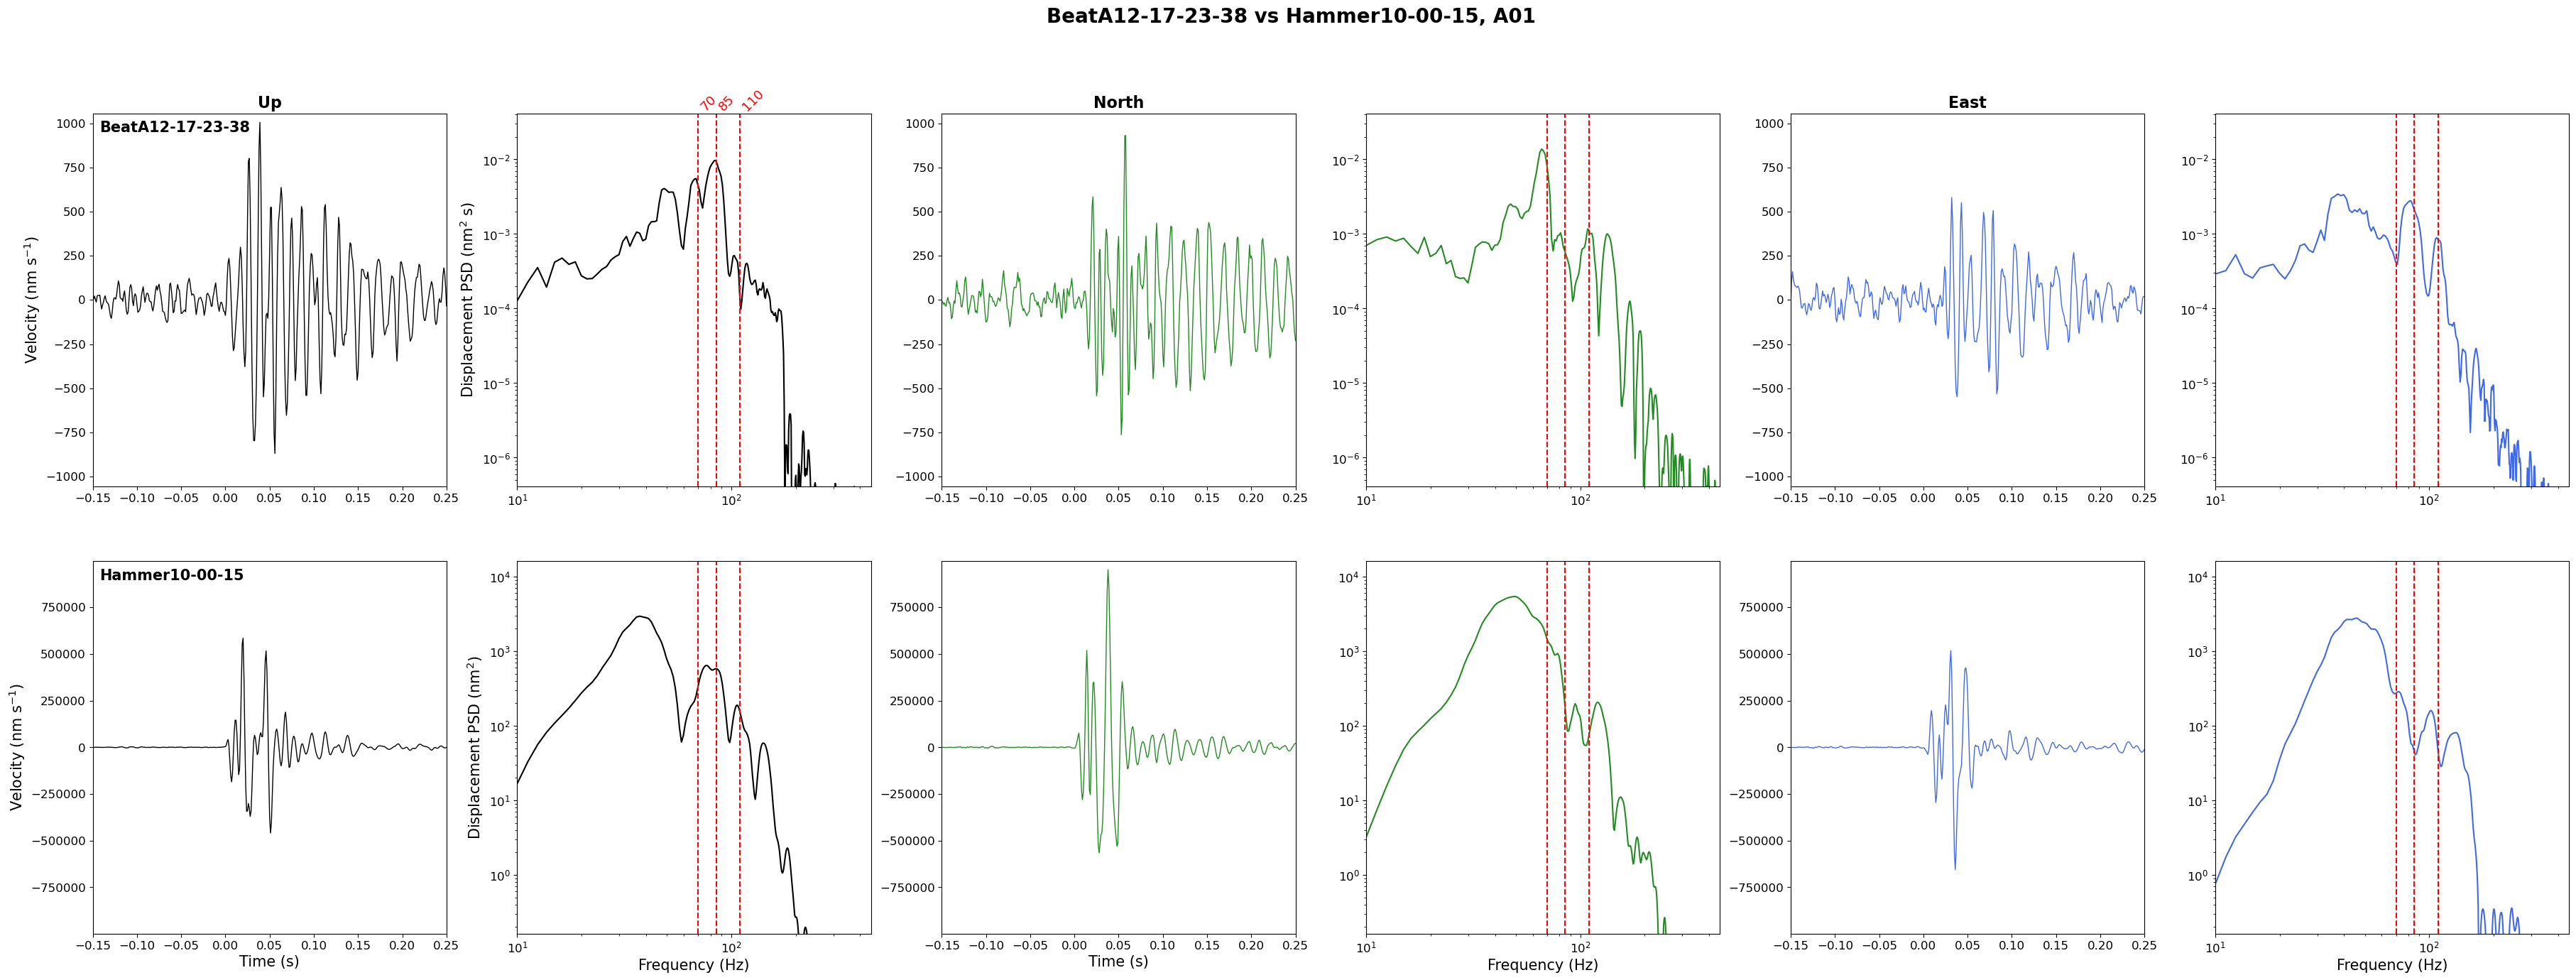

In [78]:
# Plot the waveforms and spectra
fig, axes = subplots(2, 6, figsize=(45, 15))

velmax_harmo = amax([amax(abs(data_harmo_z)), amax(abs(data_harmo_1)), amax(abs(data_harmo_2))]) * scale_wf
velmax_hammer = amax([amax(abs(data_hammer_z)), amax(abs(data_hammer_1)), amax(abs(data_hammer_2))]) * scale_wf

psdmax_harmo = amax([amax(psd_harmo_z), amax(psd_harmo_1), amax(psd_harmo_2)]) * scale_psd
psdmax_hammer = amax([amax(psd_hammer_z), amax(psd_hammer_1), amax(psd_hammer_2)]) * scale_psd

psdmin_harmo = psdmax_harmo / range_psd
psdmin_hammer = psdmax_hammer / range_psd

## Plot the Z component

### Waveforms
axes[0, 0].plot(timeax_harmo, data_harmo_z, color="black", linewidth=linewidth_wf)
axes[0, 0].set_title("Up", fontsize=16, fontweight="bold")
axes[0, 0].set_xlim(begin_read, end_read)
axes[0, 0].set_ylim(-velmax_harmo, velmax_harmo)
axes[0, 0].set_ylabel("Velocity (nm s$^{-1}$)", fontsize=15)

axes[0, 0].text(0.02, 0.98, name_harmo, fontsize=15, ha="left", va="top", fontweight="bold", transform=axes[0, 0].transAxes)

axes[1, 0].plot(timeax_hammer, data_hammer_z, color="black", linewidth=linewidth_wf)
axes[1, 0].set_xlim(begin_read, end_read)
axes[1, 0].set_ylim(-velmax_hammer, velmax_hammer)
axes[1, 0].set_xlabel("Time (s)", fontsize=15)
axes[1, 0].set_ylabel("Velocity (nm s$^{-1}$)", fontsize=15)

axes[1, 0].text(0.02, 0.98, name_hammer, fontsize=15, ha="left", va="top", fontweight="bold", transform=axes[1, 0].transAxes)

### PSDs
axes[0, 1].loglog(freqax, psd_harmo_z, color="black", linewidth=linewidth_psd)
axes[0, 1].set_xlim(freqmin_plot, freqmax_plot)
axes[0, 1].set_ylim(psdmin_harmo, psdmax_harmo)
axes[0, 1].set_ylabel("Displacement PSD (nm$^2$ s)", fontsize=15)

axes[0, 1].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 1].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 1].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)

axes[0, 1].text(freq1, psdmax_harmo, f"{freq1:.0f}", color="red", fontsize=13, ha="left", va="bottom", rotation=45)
axes[0, 1].text(freq2, psdmax_harmo, f"{freq2:.0f}", color="red", fontsize=13, ha="left", va="bottom", rotation=45)
axes[0, 1].text(freq3, psdmax_harmo, f"{freq3:.0f}", color="red", fontsize=13, ha="left", va="bottom", rotation=45)

axes[1, 1].loglog(freqax, psd_hammer_z, color="black", linewidth=linewidth_psd)
axes[1, 1].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 1].set_ylim(psdmin_hammer, psdmax_hammer)
axes[1, 1].set_xlabel("Frequency (Hz)", fontsize=15)
axes[1, 1].set_ylabel("Displacement PSD (nm$^2$)", fontsize=15)

axes[1, 1].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 1].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 1].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)


## Plot the 1 component

### Waveforms
axes[0, 2].plot(timeax_harmo, data_harmo_1, color="forestgreen", linewidth=linewidth_wf)
axes[0, 2].set_title("North", fontsize=16, fontweight="bold")
axes[0, 2].set_xlim(begin_read, end_read)
axes[0, 2].set_ylim(-velmax_harmo, velmax_harmo)

axes[1, 2].plot(timeax_hammer, data_hammer_1, color="forestgreen", linewidth=linewidth_wf)
axes[1, 2].set_xlim(begin_read, end_read)
axes[1, 2].set_ylim(-velmax_hammer, velmax_hammer)
axes[1, 2].set_xlabel("Time (s)", fontsize=15)

### PSDs
axes[0, 3].loglog(freqax, psd_harmo_1, color="forestgreen", linewidth=linewidth_psd)
axes[0, 3].set_xlim(freqmin_plot, freqmax_plot)
axes[0, 3].set_ylim(psdmin_harmo, psdmax_harmo)

axes[0, 3].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 3].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 3].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)

axes[1, 3].loglog(freqax, psd_hammer_1, color="forestgreen", linewidth=linewidth_psd)
axes[1, 3].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 3].set_ylim(psdmin_hammer, psdmax_hammer)
axes[1, 3].set_xlabel("Frequency (Hz)", fontsize=15)

axes[1, 3].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 3].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 3].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)

## Plot the 2 component

### Waveforms
axes[0, 4].plot(timeax_harmo, data_harmo_2, color="royalblue", linewidth=linewidth_wf)
axes[0, 4].set_title("East", fontsize=16, fontweight="bold")
axes[0, 4].set_xlim(begin_read, end_read)
axes[0, 4].set_ylim(-velmax_harmo, velmax_harmo)

axes[1, 4].plot(timeax_hammer, data_hammer_2, color="royalblue", linewidth=linewidth_wf)
axes[1, 4].set_xlim(begin_read, end_read)
axes[1, 4].set_ylim(-velmax_hammer, velmax_hammer)

### PSDs
axes[0, 5].loglog(freqax, psd_harmo_2, color="royalblue", linewidth=linewidth_psd)
axes[0, 5].set_xlim(freqmin_plot, freqmax_plot)
axes[0, 5].set_ylim(psdmin_harmo, psdmax_harmo)

axes[0, 5].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 5].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[0, 5].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)

axes[1, 5].loglog(freqax, psd_hammer_2, color="royalblue", linewidth=linewidth_psd)
axes[1, 5].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 5].set_ylim(psdmin_hammer, psdmax_hammer)
axes[1, 5].set_xlabel("Frequency (Hz)", fontsize=15)

axes[1, 5].axvline(x=freq1, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 5].axvline(x=freq2, color="red", linestyle="--", linewidth=linewidth_psd)
axes[1, 5].axvline(x=freq3, color="red", linestyle="--", linewidth=linewidth_psd)

## Set the font size of tick labels for all subplots
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
# axes[1, 4].set_xlabel("Time (s)", fontsize=15)

## Set the super title
fig.suptitle(f"{name_harmo} vs {name_hammer}, {station}", fontsize=20, fontweight="bold")

## Save the figure

### Create the output directory
outdir = join(ROOTDIR, "spetrum_comparison")
if not exists(outdir):
    makedirs(outdir)
    print(f"Created the output directory: {outdir}")

### Write the figure
figname = f"{name_harmo}_vs_{name_hammer}_{station}.png"
outpath = join(outdir, figname)
fig.patch.set_alpha(0)

fig.savefig(outpath, dpi=300)
print(f"Saved the figure: {outpath}")


